<a href="https://colab.research.google.com/github/Maneekul/Senior/blob/main/Basic_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic NN, Check acc and loss

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deba
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install mplfinance
!pip install ta
!pip install pytorch-ignite


Selecting previously unselected package libta-lib0.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_5.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

     ━━━━━━━━

In [ ]:
import yfinance as yf
import talib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from ignite.handlers import EarlyStopping

from torch.utils.data import DataLoader, TensorDataset


In [ ]:
# Define the normalize_min_max function
def normalize_min_max(values):
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    return normalized_values


The technical indicator feature

In [ ]:
import pandas as pd
import yfinance as yf
import talib

# List of stocks
My_ticker = ["AAPL", "MSFT", "WMB"]
#My_ticker = ["AAPL", "MSFT"]

# Candlestick patterns to plot
candlestick_patterns = [
    "CDL2CROWS", "CDL3BLACKCROWS", "CDL3INSIDE", "CDL3LINESTRIKE", "CDL3OUTSIDE",
    "CDL3STARSINSOUTH", "CDL3WHITESOLDIERS", "CDLABANDONEDBABY", "CDLADVANCEBLOCK",
    "CDLBELTHOLD", "CDLBREAKAWAY", "CDLCLOSINGMARUBOZU", "CDLCONCEALBABYSWALL",
    "CDLCOUNTERATTACK", "CDLDARKCLOUDCOVER", "CDLDOJI", "CDLDOJISTAR", "CDLDRAGONFLYDOJI",
    "CDLENGULFING", "CDLEVENINGDOJISTAR", "CDLEVENINGSTAR", "CDLGAPSIDESIDEWHITE",
    "CDLGRAVESTONEDOJI", "CDLHAMMER", "CDLHANGINGMAN", "CDLHARAMI", "CDLHARAMICROSS",
    "CDLHIGHWAVE", "CDLHIKKAKE", "CDLHIKKAKEMOD", "CDLHOMINGPIGEON", "CDLIDENTICAL3CROWS",
    "CDLINNECK", "CDLINVERTEDHAMMER", "CDLKICKING", "CDLKICKINGBYLENGTH", "CDLLADDERBOTTOM",
    "CDLLONGLEGGEDDOJI", "CDLLONGLINE", "CDLMARUBOZU", "CDLMATCHINGLOW", "CDLMATHOLD",
    "CDLMORNINGDOJISTAR", "CDLMORNINGSTAR", "CDLONNECK", "CDLPIERCING", "CDLRICKSHAWMAN",
    "CDLRISEFALL3METHODS", "CDLSEPARATINGLINES", "CDLSHOOTINGSTAR", "CDLSHORTLINE",
    "CDLSPINNINGTOP", "CDLSTALLEDPATTERN", "CDLSTICKSANDWICH", "CDLTAKURI",
    "CDLTASUKIGAP", "CDLTHRUSTING", "CDLTRISTAR", "CDLUNIQUE3RIVER", "CDLUPSIDEGAP2CROWS",
    "CDLXSIDEGAP3METHODS"
]


pattern_data = {}
combined_normalized_df = pd.DataFrame()

normalized_dfs = []

stock_pattern_data = {}

for ticker in My_ticker:
    for pattern in candlestick_patterns:
        data = yf.download(ticker, start="2019-01-01", end="2023-01-01")
        pattern_values = getattr(talib, pattern)(data['Open'], data['High'], data['Low'], data['Close'])
        normalized_pattern_values = pattern_values
        col_name = f"Normalized_{pattern}_{ticker}"
        # Store the normalized pattern values in the dictionary
        if col_name not in pattern_data:
            pattern_data[col_name] = normalized_pattern_values
        else:
            pattern_data[col_name] = pd.concat([pattern_data[col_name], normalized_pattern_values], axis=1)

        pattern_df = pd.DataFrame(pattern_data, index=data.index)

    #####################################################################################################################################################################################
    # Calculate ADX
    period_ADX = 2
    adx_values = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=period_ADX)
    adx_df = pd.DataFrame(adx_values, index=data.index, columns=[f"ADX_{ticker}"])
    # Calculate APO
    fast_period_apo = 12
    slow_period_apo = 26
    apo_values = talib.APO(data['Close'], fastperiod=fast_period_apo, slowperiod=slow_period_apo, matype=0)
    apo_df = pd.DataFrame(apo_values, index=data.index, columns=[f"APO_{ticker}"])
    # Calculate CCI
    cci_values = talib.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
    cci_df = pd.DataFrame(cci_values, index=data.index, columns=[f"CCI_{ticker}"])
    # Calculate CMO
    cmo_values = talib.CMO(data['Close'], timeperiod=14)
    cmo_df = pd.DataFrame(cmo_values, index=data.index, columns=[f"CMO_{ticker}"])
    # Calculate DX
    dx_values = talib.DX(data['High'], data['Low'], data['Close'], timeperiod=14)
    dx_df = pd.DataFrame(dx_values, index=data.index, columns=[f"DX_{ticker}"])
    # Calculate MFI
    period_mfi = 14
    mfi_values = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=period_mfi)
    mfi_df = pd.DataFrame(mfi_values, index=data.index, columns=[f"MFI_{ticker}"])
    # Calculate MINUS_DI
    period = 14
    minus_di_values = talib.MINUS_DI(data['High'], data['Low'], data['Close'], timeperiod=period)
    minus_di_df = pd.DataFrame(minus_di_values, index=data.index, columns=[f"MINUS_DI_{ticker}"])
    # Calculate MINUS_DM
    minus_dm_values = talib.MINUS_DM(data['High'], data['Low'], timeperiod=period)
    minus_dm_df = pd.DataFrame(minus_dm_values, index=data.index, columns=[f"MINUS_DM_{ticker}"])
    # Calculate MOM
    mom_values = talib.MOM(data['Close'], timeperiod=period)
    mom_df = pd.DataFrame(mom_values, index=data.index, columns=[f"MOM_{ticker}"])
    # Calculate PLUS_DI
    plus_di_values = talib.PLUS_DI(data['High'], data['Low'], data['Close'], timeperiod=period)
    plus_di_df = pd.DataFrame(plus_di_values, index=data.index, columns=[f"PLUS_DI_{ticker}"])
    # Calculate PLUS_DM
    plus_dm_values = talib.PLUS_DM(data['High'], data['Low'], timeperiod=period)
    plus_dm_df = pd.DataFrame(plus_dm_values, index=data.index, columns=[f"PLUS_DM_{ticker}"])
    # Calculate ROC
    period_roc = 12
    roc_values = talib.ROC(data['Close'], timeperiod=period_roc)
    roc_df = pd.DataFrame(roc_values, index=data.index, columns=[f"ROC_{ticker}"])
    # Calculate MFI
    period_mfi = 14
    mfi_values = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=period_mfi)
    mfi_df = pd.DataFrame(mfi_values, index=data.index, columns=[f"MFI_{ticker}"])
    # Calculate ULTOSC
    ultosc_values = talib.ULTOSC(data['High'], data['Low'], data['Close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
    ultosc_df = pd.DataFrame(ultosc_values, index=data.index, columns=[f"ULTOSC_{ticker}"])
    # Calculate MACD
    macd,_,_ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    macd_df = pd.DataFrame(macd, index=data.index, columns=[f"MACD_{ticker}"])
    # Calculate MACDEXT
    macdext,_,_ = talib.MACDEXT(data['Close'], fastperiod=12, fastmatype=1, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=1)
    macdext_df = pd.DataFrame(macd, index=data.index, columns=[f"MACDEXT_{ticker}"])
    # Calculate MACDFIX
    macdfix,_,_ = talib.MACDFIX(data['Close'], signalperiod=9)
    macdfix_df = pd.DataFrame(macdfix, index=data.index, columns=[f"MACDFIX_{ticker}"])
    # Calculate PPO
    ppo_values = talib.PPO(data['Close'], fastperiod=12, slowperiod=26, matype=0)
    ppo_df = pd.DataFrame(ppo_values, index=data.index, columns=[f"PPO_{ticker}"])
    # Calculate RSI
    rsi_values = talib.RSI(data['Close'], timeperiod=14)
    rsi_df = pd.DataFrame(rsi_values, index=data.index, columns=[f"RSI_{ticker}"])
    ###########################################
    ###########################################
    #####  Normalize by normalize_min_max #####
    # Normalize ADX values
    normalized_adx_values = normalize_min_max(adx_df[f"ADX_{ticker}"])
    normalized_adx_ticker_df = pd.DataFrame({f"Normalized_ADX_{ticker}": normalized_adx_values}, index=adx_df.index)
    # Normalize APO values
    normalized_apo_values = normalize_min_max(apo_df[f"APO_{ticker}"])
    normalized_apo_ticker_df = pd.DataFrame({f"Normalized_APO_{ticker}": normalized_apo_values}, index=apo_df.index)
    # Normalize CCI values
    normalized_cci_values= normalize_min_max(cci_df[f"CCI_{ticker}"])
    normalized_cci_values_df = pd.DataFrame({f"Normalized_CCI_{ticker}": normalized_cci_values}, index=cci_df.index)
    # Normalize CMO values
    normalized_cmo_values = normalize_min_max(cmo_df[f"CMO_{ticker}"])
    normalized_cmo_values_df = pd.DataFrame({f"Normalized_CMO_{ticker}": normalized_cmo_values}, index=cmo_df.index)
    # Normalize DX values
    normalized_dx_values = normalize_min_max(dx_df[f"DX_{ticker}"])
    normalized_dx_values_df = pd.DataFrame({f"Normalized_DX_{ticker}": normalized_dx_values}, index=dx_df.index)
    # Normalize MINUS_DI
    normalized_minus_di_values = normalize_min_max(minus_di_df[f"MINUS_DI_{ticker}"])
    normalized_minus_di_values_df = pd.DataFrame({f"Normalized_MINUS_DI_{ticker}": normalized_minus_di_values}, index=minus_di_df.index)
    # Normalize MINUS_DM
    normalized_minus_dm_values = normalize_min_max(minus_dm_df[f"MINUS_DM_{ticker}"])
    normalized_minus_dm_values_df = pd.DataFrame({f"Normalized_MINUS_DM_{ticker}": normalized_minus_dm_values}, index=minus_dm_df.index)
    # Normalize MOM values
    normalized_mom_values = normalize_min_max(mom_df[f"MOM_{ticker}"])
    normalized_mom_values_df = pd.DataFrame({f"Normalized_MOM_{ticker}": normalized_mom_values}, index=mom_df.index)
    # Normalize PLUS_DI values
    normalized_plus_di_values = normalize_min_max(plus_di_df[f"PLUS_DI_{ticker}"])
    normalized_plus_di_values_df = pd.DataFrame({f"Normalized_PLUS_DI_{ticker}": normalized_plus_di_values}, index=plus_di_df.index)
    # Normalize PLUS_DM values
    normalized_plus_dm_values= normalize_min_max(plus_dm_df[f"PLUS_DM_{ticker}"])
    normalized_plus_dm_values_df = pd.DataFrame({f"Normalized_PLUS_DM_{ticker}": normalized_plus_dm_values}, index=plus_dm_df.index)
    # Normalize MFI values
    normalized_mfi_values = normalize_min_max(mfi_df[f"MFI_{ticker}"])
    normalized_mfi_values_df = pd.DataFrame({f"Normalized_MFI_{ticker}": normalized_mfi_values}, index=mfi_df.index)
    # Normalize ROC values
    normalized_roc_values = normalize_min_max(roc_df[f"ROC_{ticker}"])
    normalized_roc_values_df = pd.DataFrame({f"Normalized_ROC_{ticker}": normalized_roc_values}, index=roc_df.index)
    # Normalize ULTOSC values
    normalized_ultosc_values = normalize_min_max(ultosc_df[f"ULTOSC_{ticker}"])
    normalized_ultosc_values_df = pd.DataFrame({f"Normalized_ULTOSC_{ticker}": normalized_ultosc_values}, index=ultosc_df.index)
    # Normalize MACD values
    normalized_macd = normalize_min_max(macd_df[f"MACD_{ticker}"])
    normalized_macd_df = pd.DataFrame({f"Normalized_MACD_{ticker}": normalized_macd}, index=macd_df.index)
    # Normalize MACDEXT values
    normalized_macdext = normalize_min_max(macdext_df[f"MACDEXT_{ticker}"])
    normalized_macdext_df = pd.DataFrame({f"Normalized_MACDEXT_{ticker}": normalized_macdext}, index=macdext_df.index)
    # Normalize MACDFIX values
    normalized_macdfix = normalize_min_max(macdfix_df[f"MACDFIX_{ticker}"])
    normalized_macdfix_df = pd.DataFrame({f"Normalized_MACDFIX_{ticker}": normalized_macd}, index=macdfix_df.index)
    # Normalize PPO values
    normalized_ppo_values = normalize_min_max(ppo_df[f"PPO_{ticker}"])
    normalized_ppo_values_df = pd.DataFrame({f"Normalized_PPO_{ticker}": normalized_ppo_values}, index=ppo_df.index)
    # Normalize RSI values
    normalized_rsi_values = normalize_min_max(rsi_df[f"RSI_{ticker}"])
    normalized_rsi_values_df = pd.DataFrame({f"Normalized_RSI_{ticker}": normalized_rsi_values}, index=rsi_df.index)
    ###############################################
    ###############################################
    #####  Normalize already with divide 100  #####
    # Calculate STOCHRSI
    fastk_rsi, fastd_rsi = talib.STOCHRSI(data['Close'], timeperiod=14, fastk_period=5, fastd_period=3)
    fastk_rsi_df = (pd.DataFrame(fastk_rsi, index=data.index, columns=[f"STOCHRSI_fastk_{ticker}"]))/100
    fastd_rsi_df = (pd.DataFrame(fastd_rsi, index=data.index, columns=[f"STOCHRSI_fastd_{ticker}"]))/100
    # Calculate STOCHF
    k, d = talib.STOCHF(data['High'], data['Low'], data['Close'])
    k_df = (pd.DataFrame(k, index=data.index, columns=[f"STOCHF_k_{ticker}"]))/100
    d_df = (pd.DataFrame(d, index=data.index, columns=[f"STOCHF_d_{ticker}"]))/100
    # Calculate Aroon
    aroon_up, aroon_down = talib.AROON(data['High'], data['Low'], timeperiod=14)
    aroon_up_df = (pd.DataFrame(aroon_up, index=data.index, columns=[f"Aroon_Up_{ticker}"]))/100
    aroon_down_df = (pd.DataFrame(aroon_down, index=data.index, columns=[f"Aroon_Down_{ticker}"])) /100
    # Calculate Aroon Oscillator
    aroon_oscillator = talib.AROONOSC(data['High'], data['Low'], timeperiod=14)
    aroon_oscillator_df = (pd.DataFrame(aroon_oscillator, index=data.index, columns=[f"AROONOSC_{ticker}"]))/100
    # Calculate Stochastic Oscillator
    fastk, fastd = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    fastk_df = (pd.DataFrame(fastk, index=data.index, columns=[f"%K_fastk_{ticker}"]))/100
    fastd_df = (pd.DataFrame(fastd, index=data.index, columns=[f"%D_fastd_{ticker}"]))/100
    # Calculate WILLR (Williams' %R)
    willr_values = talib.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)
    willr_df = (pd.DataFrame(willr_values, index=data.index, columns=[f"WILLR_{ticker}"]))/100
    #####################################################################################################################################################################################
    # Calculate Chaikin AD Oscillator
    ad_oscillator = talib.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=10)
    ad_oscillator_df = pd.DataFrame(ad_oscillator, index=data.index, columns=[f"Chaikin AD Oscillator_{ticker}"])
    # Calculate NATR
    natr = talib.NATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    natr_df = pd.DataFrame(natr, index=data.index, columns=[f"NATR_{ticker}"])
    # Calculate HT_DCPERIOD
    ht_dcperiod = talib.HT_DCPERIOD(data['Close'])
    ht_dcperiod_df = pd.DataFrame(ht_dcperiod, index=data.index, columns=[f"ht_dcperiod_{ticker}"])
    # Calculate HT_DCPHASE
    ht_dcphase = talib.HT_DCPHASE(data['Close'])
    ht_dcphase_df = pd.DataFrame(ht_dcphase, index=data.index, columns=[f"ht_dcphase_{ticker}"])
    # Calculate HT_PHASOR
    ht_phasor, _ = talib.HT_PHASOR(data['Close'])
    ht_phasor_df = pd.DataFrame(ht_phasor, index=data.index, columns=[f"ht_phasor_{ticker}"])
    ###########################################
    ###########################################
    #####  Normalize by normalize_min_max #####
    # Normalize Chaikin AD Oscillator values
    normalized_ad_oscillator_values = normalize_min_max(ad_oscillator_df[f"Chaikin AD Oscillator_{ticker}"])
    normalized_ad_oscillator_values_df = pd.DataFrame({f"Normalized_ad_oscillator_{ticker}":normalized_ad_oscillator_values}, index=ad_oscillator_df.index)
    # Normalize NATR values
    normalized_natr_df_values = normalize_min_max(natr_df[f"NATR_{ticker}"])
    normalized_natr_df_values_df = pd.DataFrame({f"Normalized_natr_df_{ticker}":normalized_natr_df_values}, index=natr_df.index)
    # Normalize HT_DCPERIOD values
    normalized_dcperiod = normalize_min_max(ht_dcperiod_df[f"ht_dcperiod_{ticker}"])
    normalized_dcperiod_df = pd.DataFrame({f"Normalized_ht_dcperiod_df_{ticker}":normalized_dcperiod}, index=ht_dcperiod_df.index)
    # Normalize HT_DCPHASE values
    normalized_dcphase = normalize_min_max(ht_dcphase_df[f"ht_dcphase_{ticker}"])
    normalized_dcphase_df = pd.DataFrame({f"Normalized_ht_dcphase_df_{ticker}":normalized_dcphase}, index=ht_dcphase_df.index)
    # Normalize HT_PHASOR values
    normalized_phasor = normalize_min_max(ht_phasor_df[f"ht_phasor_{ticker}"])
    normalized_phasor_df = pd.DataFrame({f"Normalized_normalized_phasor_{ticker}":normalized_phasor}, index=ht_phasor_df.index)
    #####################################################################################################################################################################################
    # Calculate BETA
    beta = talib.BETA(data['High'], data['Low'], timeperiod=14)
    beta_df = pd.DataFrame(beta, index=data.index, columns=[f"BETA_{ticker}"])
    # Calculate CORREL
    corr = talib.CORREL(data['High'], data['Low'], timeperiod=14)
    corr_df = pd.DataFrame(corr, index=data.index, columns=[f"CORREL_{ticker}"])
    # Calculate LINEARREG_ANGL
    linear_reg_angle = talib.LINEARREG_ANGLE(data['Close'], timeperiod=14)
    linear_reg_angle_df = pd.DataFrame(linear_reg_angle, index=data.index, columns=[f"LINEARREG_ANGLE_{ticker}"])
    # Calculate LINEARREG_SLOPE
    linear_reg_slope = talib.LINEARREG_SLOPE(data['Close'], timeperiod=14)
    linear_reg_slope_df = pd.DataFrame(linear_reg_slope, index=data.index, columns=[f"LINEARREG_SLOPE_{ticker}"])
    ###########################################
    ###########################################
    #####  Normalize by normalize_min_max #####
    # Normalize BETA values
    normalized_beta = normalize_min_max(beta_df[f"BETA_{ticker}"])
    normalized_beta_df = pd.DataFrame({f"Normalized_BETA_{ticker}": normalized_beta}, index=beta_df.index)
    # Normalize LINEARREG_ANGL values
    normalized_linear_reg_angle = normalize_min_max(linear_reg_angle_df[f"LINEARREG_ANGLE_{ticker}"])
    normalized_linear_reg_angle_df = pd.DataFrame({f"Normalized_LINEARREG_ANGLE_{ticker}": normalized_linear_reg_angle}, index=linear_reg_angle_df.index)
    # Normalize LINEARREG_SLOPE values
    normalized_linear_reg_slope = normalize_min_max(linear_reg_slope_df[f"LINEARREG_SLOPE_{ticker}"])
    normalized_linear_reg_slope_df = pd.DataFrame({f"Normalized_LINEARREG_SLOPE_{ticker}": normalized_linear_reg_slope}, index=linear_reg_slope_df.index)
    #####################################################################################################################################################################################
    # Calculate HT_SINE
    ht_sine, _ = talib.HT_SINE(data['Close'])
    ht_sine_df = pd.DataFrame(ht_sine, index=data.index, columns=[f"HT_SINE_{ticker}"])
    # Calculate HT_TRENDMODE
    ht_trendmode = talib.HT_TRENDMODE(data['Close'])
    ht_trendmode_df = pd.DataFrame(ht_trendmode, index=data.index, columns=[f"HT_TRENDMODE_{ticker}"])
    # Calculate ROCP
    rocp_values = talib.ROCP(data['Close'])
    rocp_df = pd.DataFrame(rocp_values, index=data.index, columns=[f"ROCP_{ticker}"])
    # Calculate ROCR (Rate of change ratio)
    rocr_values = talib.ROCR(data['Close'])
    rocr_df = pd.DataFrame(rocr_values, index=data.index, columns=[f"ROCR_{ticker}"])
    # Calculate TRIX
    trix_values = talib.TRIX(data['Close'], timeperiod=14)
    trix_df = pd.DataFrame(trix_values, index=data.index, columns=[f"TRIX_{ticker}"])
    # Calculate BOP
    bop_values = talib.BOP(data['Open'], data['High'], data['Low'], data['Close'])
    bop_df = pd.DataFrame(bop_values, index=data.index, columns=[f"BOP_{ticker}"])



    combined_normalized_df = pd.concat([combined_normalized_df,
                                        normalized_adx_ticker_df,
                                        normalized_apo_ticker_df,
                                        normalized_cci_values_df,
                                        normalized_cmo_values_df,
                                        normalized_dx_values_df,
                                        normalized_minus_di_values_df,
                                        normalized_minus_dm_values_df,
                                        normalized_mom_values_df,
                                        normalized_plus_di_values_df,
                                        normalized_plus_dm_values_df,
                                        normalized_mfi_values_df,
                                        normalized_roc_values_df,
                                        normalized_ultosc_values_df,
                                        normalized_macd_df,
                                        normalized_macdext_df,
                                        normalized_macdfix_df,
                                        normalized_ppo_values_df,
                                        normalized_rsi_values_df,
                                        fastk_rsi_df,
                                        fastd_rsi_df,
                                        k_df,
                                        d_df,
                                        ht_sine_df,
                                        ht_trendmode_df,
                                        rocp_df,
                                        rocr_df,
                                        trix_df,
                                        bop_df,
                                        normalized_beta_df,
                                        normalized_linear_reg_angle_df,
                                        normalized_linear_reg_slope_df,
                                        corr_df,
                                        aroon_up_df,
                                        aroon_down_df,
                                        aroon_oscillator_df,
                                        fastk_df,
                                        fastd_df,
                                        willr_df,
                                        normalized_ad_oscillator_values_df,
                                        normalized_natr_df_values_df,
                                        normalized_dcperiod_df,
                                        normalized_dcphase_df,
                                        normalized_phasor_df,
                                        pattern_df,], axis=1)

combined_normalized_df.dropna(inplace=True)
combined_normalized_df = combined_normalized_df.loc[:, ~combined_normalized_df.columns.duplicated()]




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
combined_normalized_df

,Normalized_ADX_AAPL,Normalized_APO_AAPL,Normalized_CCI_AAPL,Normalized_CMO_AAPL,Normalized_DX_AAPL,Normalized_MINUS_DI_AAPL,Normalized_MINUS_DM_AAPL,Normalized_MOM_AAPL,Normalized_PLUS_DI_AAPL,Normalized_PLUS_DM_AAPL,...,Normalized_CDLSPINNINGTOP_WMB,Normalized_CDLSTALLEDPATTERN_WMB,Normalized_CDLSTICKSANDWICH_WMB,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-03,0.835270,0.599913,0.775856,0.756412,0.619985,0.144455,0.019944,0.578825,0.612696,0.097562,...,0,0,0,0,0,0,0,0,0,0
2019-04-04,0.895160,0.599382,0.733731,0.762943,0.619161,0.124399,0.016145,0.568440,0.560849,0.083883,...,0,0,0,0,0,0,0,0,0,0
2019-04-05,0.935489,0.596815,0.747290,0.788304,0.641768,0.115594,0.012537,0.565451,0.572731,0.078681,...,0,0,0,0,0,0,0,0,0,0
2019-04-08,0.966799,0.589014,0.776007,0.842458,0.729674,0.092182,0.009186,0.588703,0.655996,0.098508,...,0,0,0,0,0,0,0,0,0,0
2019-04-09,0.984201,0.586096,0.787388,0.811018,0.791410,0.072143,0.006075,0.577406,0.713731,0.111678,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.358988,0.220800,0.376915,0.135480,0.283540,0.645784,0.629123,0.220669,0.274597,0.450220,...,0,0,0,0,0,0,0,0,0,0
2022-12-27,0.476898,0.206257,0.376423,0.100428,0.313072,0.641169,0.611492,0.258967,0.249621,0.411352,...,100,0,0,0,0,0,0,0,0,0
2022-12-28,0.676917,0.185106,0.357011,0.031876,0.400469,0.688538,0.657555,0.218034,0.211188,0.375260,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(len(candlestick_patterns))

61


In [ ]:
column_names = combined_normalized_df.columns.tolist()
column_names

['Normalized_ADX_AAPL',
 'Normalized_APO_AAPL',
 'Normalized_CCI_AAPL',
 'Normalized_CMO_AAPL',
 'Normalized_DX_AAPL',
 'Normalized_MINUS_DI_AAPL',
 'Normalized_MINUS_DM_AAPL',
 'Normalized_MOM_AAPL',
 'Normalized_PLUS_DI_AAPL',
 'Normalized_PLUS_DM_AAPL',
 'Normalized_MFI_AAPL',
 'Normalized_ROC_AAPL',
 'Normalized_ULTOSC_AAPL',
 'Normalized_MACD_AAPL',
 'Normalized_MACDEXT_AAPL',
 'Normalized_MACDFIX_AAPL',
 'Normalized_PPO_AAPL',
 'Normalized_RSI_AAPL',
 'STOCHRSI_fastk_AAPL',
 'STOCHRSI_fastd_AAPL',
 'STOCHF_k_AAPL',
 'STOCHF_d_AAPL',
 'HT_SINE_AAPL',
 'HT_TRENDMODE_AAPL',
 'ROCP_AAPL',
 'ROCR_AAPL',
 'TRIX_AAPL',
 'BOP_AAPL',
 'Normalized_BETA_AAPL',
 'Normalized_LINEARREG_ANGLE_AAPL',
 'Normalized_LINEARREG_SLOPE_AAPL',
 'CORREL_AAPL',
 'Aroon_Up_AAPL',
 'Aroon_Down_AAPL',
 'AROONOSC_AAPL',
 '%K_fastk_AAPL',
 '%D_fastd_AAPL',
 'WILLR_AAPL',
 'Normalized_ad_oscillator_AAPL',
 'Normalized_natr_df_AAPL',
 'Normalized_ht_dcperiod_df_AAPL',
 'Normalized_ht_dcphase_df_AAPL',
 'Normaliz

In [ ]:
# Shift colomns for matching dailyreturn
combined__normalized_df_shift = combined_normalized_df.shift(1)
combined__normalized_df_shift.dropna(inplace=True)
combined__normalized_df_shift

,Normalized_ADX_AAPL,Normalized_APO_AAPL,Normalized_CCI_AAPL,Normalized_CMO_AAPL,Normalized_DX_AAPL,Normalized_MINUS_DI_AAPL,Normalized_MINUS_DM_AAPL,Normalized_MOM_AAPL,Normalized_PLUS_DI_AAPL,Normalized_PLUS_DM_AAPL,...,Normalized_CDLSPINNINGTOP_WMB,Normalized_CDLSTALLEDPATTERN_WMB,Normalized_CDLSTICKSANDWICH_WMB,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-04,0.835270,0.599913,0.775856,0.756412,0.619985,0.144455,0.019944,0.578825,0.612696,0.097562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-05,0.895160,0.599382,0.733731,0.762943,0.619161,0.124399,0.016145,0.568440,0.560849,0.083883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-08,0.935489,0.596815,0.747290,0.788304,0.641768,0.115594,0.012537,0.565451,0.572731,0.078681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-09,0.966799,0.589014,0.776007,0.842458,0.729674,0.092182,0.009186,0.588703,0.655996,0.098508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-10,0.984201,0.586096,0.787388,0.811018,0.791410,0.072143,0.006075,0.577406,0.713731,0.111678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.351121,0.226796,0.372792,0.142534,0.262886,0.656498,0.657168,0.204255,0.297252,0.492079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-27,0.358988,0.220800,0.376915,0.135480,0.283540,0.645784,0.629123,0.220669,0.274597,0.450220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28,0.476898,0.206257,0.376423,0.100428,0.313072,0.641169,0.611492,0.258967,0.249621,0.411352,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
selected_columns1 = combined__normalized_df_shift.iloc[:, :104]
selected_columns2 = combined__normalized_df_shift.iloc[:, 104:208]
selected_columns3 = combined__normalized_df_shift.iloc[:, 208:312]
selected_columns3

,Normalized_ADX_WMB,Normalized_APO_WMB,Normalized_CCI_WMB,Normalized_CMO_WMB,Normalized_DX_WMB,Normalized_MINUS_DI_WMB,Normalized_MINUS_DM_WMB,Normalized_MOM_WMB,Normalized_PLUS_DI_WMB,Normalized_PLUS_DM_WMB,...,Normalized_CDLSPINNINGTOP_WMB,Normalized_CDLSTALLEDPATTERN_WMB,Normalized_CDLSTICKSANDWICH_WMB,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-04,0.396784,0.739601,0.725871,0.646633,0.324408,0.242060,0.086972,0.694231,0.509891,0.289148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-05,0.387949,0.738057,0.623031,0.622249,0.275634,0.255359,0.086092,0.699359,0.483596,0.260134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-08,0.355586,0.732975,0.693929,0.669358,0.379967,0.227045,0.077081,0.703205,0.541230,0.287786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-09,0.377455,0.723654,0.673486,0.638051,0.390511,0.202586,0.068714,0.674359,0.504371,0.264517,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-04-10,0.403798,0.718463,0.489176,0.559682,0.227650,0.268270,0.086435,0.641667,0.458248,0.237262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.407335,0.524752,0.403137,0.388649,0.283062,0.486225,0.286799,0.465385,0.286814,0.345683,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-27,0.296727,0.521017,0.558538,0.474528,0.144417,0.440144,0.263453,0.564103,0.351107,0.401109,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-12-28,0.327115,0.526099,0.635928,0.484273,0.107164,0.420466,0.241774,0.614743,0.361264,0.388571,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
### compare close price ###
tickers = ["AAPL", "MSFT", "WMB"]
start_date = "2019-01-01"
end_date = "2023-01-01"

daily_tickers = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    daily_tickers[f"Adj_Close_{ticker}"] = data["Adj Close"]


daily_tickers = (daily_tickers.shift(1) < daily_tickers).astype(int)
daily_tickers.columns = [f"{col}" for col in daily_tickers.columns]
print(daily_tickers)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
            Adj_Close_AAPL  Adj_Close_MSFT  Adj_Close_WMB
Date                                                     
2019-01-02               0               0              0
2019-01-03               0               0              1
2019-01-04               1               1              1
2019-01-07               0               1              1
2019-01-08               1               1              1
...                    ...             ...            ...
2022-12-23               0               1              1
2022-12-27               0               0              1
2022-12-28               0               0              0
2022-12-29               1               1              1
2022-12-30               1               0              0

[1008 rows x 3 columns]


In [ ]:
####### using dailyreturn ######
#tickers = ["AAPL", "MSFT", "WMB"]
#start_date = "2021-01-01"
#end_date = "2023-01-01"
#
#data = yf.download(tickers, start=start_date, end=end_date)
#
#percentage_changes_list = []
#My_Y_train = np.array([])
#
#for ticker in tickers:
#    percentage_changes = data['Adj Close'][ticker].pct_change().dropna() * 100
#    percentage_changes_list.append(percentage_changes)
#    My_Y_train = np.append(My_Y_train, percentage_changes.values)
#
#daily_tickers = pd.concat(percentage_changes_list, axis=1)
#daily_tickers.columns = [f"Daily_{daily_ticker}" for daily_ticker in daily_tickers.columns]
##Y_train.columns = tickers
#
#
#print(daily_tickers)
#print(My_Y_train)
#print(My_Y_train.shape)


In [ ]:
combine_stock_daily = pd.concat([combined__normalized_df_shift,daily_tickers], axis=1)
combine_stock_daily.dropna(inplace=True)
combine_stock_daily

,Normalized_ADX_AAPL,Normalized_APO_AAPL,Normalized_CCI_AAPL,Normalized_CMO_AAPL,Normalized_DX_AAPL,Normalized_MINUS_DI_AAPL,Normalized_MINUS_DM_AAPL,Normalized_MOM_AAPL,Normalized_PLUS_DI_AAPL,Normalized_PLUS_DM_AAPL,...,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB,Adj_Close_AAPL,Adj_Close_MSFT,Adj_Close_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-04,0.835270,0.599913,0.775856,0.756412,0.619985,0.144455,0.019944,0.578825,0.612696,0.097562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2019-04-05,0.895160,0.599382,0.733731,0.762943,0.619161,0.124399,0.016145,0.568440,0.560849,0.083883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2019-04-08,0.935489,0.596815,0.747290,0.788304,0.641768,0.115594,0.012537,0.565451,0.572731,0.078681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2019-04-09,0.966799,0.589014,0.776007,0.842458,0.729674,0.092182,0.009186,0.588703,0.655996,0.098508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2019-04-10,0.984201,0.586096,0.787388,0.811018,0.791410,0.072143,0.006075,0.577406,0.713731,0.111678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.351121,0.226796,0.372792,0.142534,0.262886,0.656498,0.657168,0.204255,0.297252,0.492079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2022-12-27,0.358988,0.220800,0.376915,0.135480,0.283540,0.645784,0.629123,0.220669,0.274597,0.450220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2022-12-28,0.476898,0.206257,0.376423,0.100428,0.313072,0.641169,0.611492,0.258967,0.249621,0.411352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [ ]:
all_day = combine_stock_daily.shape[0]
num_Sep1 = int(all_day*0.6)
num_Sep2 = all_day-num_Sep1
print(combine_stock_daily.shape)
print('All_day =',all_day)
print('Day_for_training =',num_Sep1)
print('Day_for_test_valid =',num_Sep2)

(944, 315)
All_day = 944
Day_for_training = 566
Day_for_test_valid = 378


In [ ]:
df_num_Sep1 = combine_stock_daily.iloc[:num_Sep1, :]  # Use for traing
df_num_Sep2 = combine_stock_daily.iloc[num_Sep1:all_day, :]  # Use for testing and validation
df_num_Sep1

,Normalized_ADX_AAPL,Normalized_APO_AAPL,Normalized_CCI_AAPL,Normalized_CMO_AAPL,Normalized_DX_AAPL,Normalized_MINUS_DI_AAPL,Normalized_MINUS_DM_AAPL,Normalized_MOM_AAPL,Normalized_PLUS_DI_AAPL,Normalized_PLUS_DM_AAPL,...,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB,Adj_Close_AAPL,Adj_Close_MSFT,Adj_Close_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-04,0.835270,0.599913,0.775856,0.756412,0.619985,0.144455,0.019944,0.578825,0.612696,0.097562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
2019-04-05,0.895160,0.599382,0.733731,0.762943,0.619161,0.124399,0.016145,0.568440,0.560849,0.083883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2019-04-08,0.935489,0.596815,0.747290,0.788304,0.641768,0.115594,0.012537,0.565451,0.572731,0.078681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2019-04-09,0.966799,0.589014,0.776007,0.842458,0.729674,0.092182,0.009186,0.588703,0.655996,0.098508,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2019-04-10,0.984201,0.586096,0.787388,0.811018,0.791410,0.072143,0.006075,0.577406,0.713731,0.111678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-25,0.595366,0.655055,0.727891,0.616295,0.355300,0.199370,0.114593,0.672341,0.391667,0.235077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2021-06-28,0.461056,0.664971,0.687393,0.595380,0.338303,0.195628,0.107835,0.666059,0.369453,0.211576,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2021-06-29,0.667061,0.689704,0.719778,0.662668,0.446352,0.168098,0.097678,0.682877,0.433204,0.245642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0


In [ ]:
num_TV = int(df_num_Sep2.shape[0] * 0.5)
print(df_num_Sep2.shape[0])
print(num_TV)

378
189


In [ ]:
Sep_Test = df_num_Sep2.iloc[:num_TV, :]
Sep_Valid = df_num_Sep2.iloc[num_TV:all_day, :]
#Sep_Test
Sep_Valid

,Normalized_ADX_AAPL,Normalized_APO_AAPL,Normalized_CCI_AAPL,Normalized_CMO_AAPL,Normalized_DX_AAPL,Normalized_MINUS_DI_AAPL,Normalized_MINUS_DM_AAPL,Normalized_MOM_AAPL,Normalized_PLUS_DI_AAPL,Normalized_PLUS_DM_AAPL,...,Normalized_CDLTAKURI_WMB,Normalized_CDLTASUKIGAP_WMB,Normalized_CDLTHRUSTING_WMB,Normalized_CDLTRISTAR_WMB,Normalized_CDLUNIQUE3RIVER_WMB,Normalized_CDLUPSIDEGAP2CROWS_WMB,Normalized_CDLXSIDEGAP3METHODS_WMB,Adj_Close_AAPL,Adj_Close_MSFT,Adj_Close_WMB
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,0.483795,0.800474,0.659429,0.549848,0.206484,0.364418,0.386366,0.922796,0.470558,0.639562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2022-04-04,0.566648,0.844897,0.618992,0.540680,0.085747,0.442742,0.435893,1.000000,0.436351,0.587169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0
2022-04-05,0.420151,0.899586,0.664399,0.623461,0.222750,0.398172,0.402303,0.993111,0.531240,0.686869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2022-04-06,0.341480,0.930333,0.631844,0.520575,0.221727,0.359115,0.371759,0.833435,0.480155,0.631097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2022-04-07,0.475002,0.942016,0.516894,0.432902,0.017091,0.496617,0.481529,0.747113,0.422562,0.579309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.351121,0.226796,0.372792,0.142534,0.262886,0.656498,0.657168,0.204255,0.297252,0.492079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1
2022-12-27,0.358988,0.220800,0.376915,0.135480,0.283540,0.645784,0.629123,0.220669,0.274597,0.450220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
2022-12-28,0.476898,0.206257,0.376423,0.100428,0.313072,0.641169,0.611492,0.258967,0.249621,0.411352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [ ]:
df_num_Sep1.iloc[:,312:315]

,Adj_Close_AAPL,Adj_Close_MSFT,Adj_Close_WMB
Date,,,
2019-04-04,1,0,0
2019-04-05,1,1,1
2019-04-08,1,1,0
2019-04-09,0,0,0
2019-04-10,1,1,0
...,...,...,...
2021-06-25,0,0,1
2021-06-28,1,1,0
2021-06-29,1,1,0


In [ ]:
df_num_Sep1.iloc[:,312:315].values

array([[1, 0, 0],
       [1, 1, 1],
       [1, 1, 0],
       ...,
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 1]])

In [ ]:
(df_num_Sep1.iloc[:,312:315].values).flatten()

array([1, 0, 0, ..., 1, 1, 1])

In [ ]:
stack_trining1 = df_num_Sep1.iloc[:, :104].values   #104 is fix
stack_trining2 = df_num_Sep1.iloc[:,104:208].values
stack_trining3 = df_num_Sep1.iloc[:,208:312].values
stacked_training_arr = np.vstack((stack_trining1, stack_trining2, stack_trining3))  #stack day

y_train = (df_num_Sep1.iloc[:,312:315].values).flatten()
#y_train = (y_train >= 0).astype(int)
print(y_train)
print("X_train_shape =",stacked_training_arr.shape)
print("y_train_shape =",y_train.shape)


[1 0 0 ... 1 1 1]
X_train_shape = (1698, 104)
y_train_shape = (1698,)


In [ ]:
stack_testing1 = Sep_Test.iloc[:, :104].values
stack_testing2 = Sep_Test.iloc[:,104:208].values
stack_testing2 = Sep_Test.iloc[:,208:312].values
stacked_testing_arr = np.vstack((stack_testing1, stack_testing2, stack_testing2))  #stack day

y_test = (Sep_Test.iloc[:,312:315].values).flatten()
#print(y_test)
print("X_test_shape =",stacked_testing_arr.shape)
print("y_test_shape =",y_test.shape)

X_test_shape = (567, 104)
y_test_shape = (567,)


In [ ]:
stack_validation1 = Sep_Valid.iloc[:, :104].values
stack_validation2 = Sep_Valid.iloc[:,104:208].values
stack_validation3 = Sep_Valid.iloc[:,208:312].values
stacked_validation_arr = np.vstack((stack_validation1, stack_validation2, stack_validation3))  #stack day

y_valid = (Sep_Valid.iloc[:,312:315].values).flatten()  # -len(tickers) --> 312:315

print("X_valid_shape =",stacked_validation_arr.shape)
print("y_valid_shape =",y_valid.shape)

X_valid_shape = (567, 104)
y_valid_shape = (567,)


In [ ]:
batch_size = 64
X_train_tensor = torch.tensor(stacked_training_arr, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

print(X_train_tensor.shape)

X_test_tensor = torch.tensor(stacked_testing_arr, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

X_valid_tensor = torch.tensor(stacked_validation_arr, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)




torch.Size([1698, 104])


In [ ]:
class BinaryPredict(nn.Module):
    def __init__(self, input_dim):
        super(BinaryPredict, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.1)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        #x = self.fc4(x)
        x = torch.sigmoid(self.fc4(x))
        return x

class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pth'):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.checkpoint_path = checkpoint_path
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            torch.save(model.state_dict(), self.checkpoint_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

def calculate_accuracy(predictions, targets):
    #binary_predictions = (predictions >= 0).float()
    correct_predictions = (predictions == targets).float().sum()
    #print('correct_predictions =',correct_predictions)
    accuracy = (correct_predictions / targets.size(0)) * 100.0
    return accuracy.item()

In [ ]:
import random
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


np.random.seed(42)
random.seed(42)

In [ ]:

num_indicator = 104
model = BinaryPredict(num_indicator)

losses = []
train_accuracies = []
val_accuracies = []
val_losses = []

criterion = nn.BCELoss()    #BCE #MSE
optimizer = torch.optim.Adam (model.parameters(), lr=0.001)  # Adam ,momentum=0.9  #SGD
early_stopping = EarlyStopping(patience=20)

num_epochs = 100

for epoch in range(num_epochs):
    avg_loss = 0.00
    avg_trainacc = 0.00
    model.train()
    for inputs, targets in train_loader:
        #print(targets)
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs.squeeze(dim=-1), targets.float()) # dim=-1
        loss.backward()

        optimizer.step()

        predicted_train = (outputs.squeeze()> 0.5).float()
        train_accuracy = calculate_accuracy(predicted_train, targets.float())
        avg_loss += loss.float()
        avg_trainacc += train_accuracy
    avg_loss /= len(train_loader)
    avg_trainacc /= len(train_loader)

    # Validation phase
    avg_validloss = 0.00
    avg_validacc = 0.00
    model.eval()
    for val_inputs, val_targets in valid_loader:
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs.squeeze(), val_targets.float())

        predicted_valid = (val_outputs.squeeze()> 0.5).float()
        val_accuracy = calculate_accuracy(predicted_valid, val_targets.float())

        avg_validloss += val_loss.float()
        avg_validacc += val_accuracy
    avg_validloss /= len(valid_loader)
    avg_validacc /= len(valid_loader)

    # Print training and validation
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_loss:.4f}, '
          f'Train Acc: {avg_trainacc:.4f}, '
          f'Val Loss: {avg_validloss:.4f}, '
          f'Val Acc: {avg_validacc:.4f}')

    losses.append(avg_loss.item())
    train_accuracies.append(avg_trainacc)
    val_losses.append(avg_validloss.item())
    val_accuracies.append(avg_validacc)

    # Check for early stopping
    #if early_stopping(val_loss, model):
    #    print(f"Early stopping triggered at epoch")
    #    break


Epoch [1/100], Train Loss: 0.7217, Train Acc: 53.6254, Val Loss: 0.7145, Val Acc: 47.1780
Epoch [2/100], Train Loss: 0.6875, Train Acc: 55.0347, Val Loss: 0.7174, Val Acc: 49.8990
Epoch [3/100], Train Loss: 0.6682, Train Acc: 57.2202, Val Loss: 0.7280, Val Acc: 49.0309
Epoch [4/100], Train Loss: 0.6604, Train Acc: 58.0984, Val Loss: 0.7319, Val Acc: 48.2765
Epoch [5/100], Train Loss: 0.6690, Train Acc: 57.8125, Val Loss: 0.7554, Val Acc: 46.9192
Epoch [6/100], Train Loss: 0.6556, Train Acc: 59.8822, Val Loss: 0.7495, Val Acc: 47.4684
Epoch [7/100], Train Loss: 0.6517, Train Acc: 59.5350, Val Loss: 0.7406, Val Acc: 49.2614
Epoch [8/100], Train Loss: 0.6580, Train Acc: 59.2218, Val Loss: 0.7541, Val Acc: 49.2614
Epoch [9/100], Train Loss: 0.6411, Train Acc: 61.4822, Val Loss: 0.7626, Val Acc: 48.4533
Epoch [10/100], Train Loss: 0.6392, Train Acc: 61.0396, Val Loss: 0.7706, Val Acc: 49.2614
Epoch [11/100], Train Loss: 0.6430, Train Acc: 60.3758, Val Loss: 0.7523, Val Acc: 48.8289
Epoch [1

In [ ]:
test_accuracies = []
test_prediction = []
model.eval()
for test_inputs, test_targets in test_loader:
    test_outputs = model(test_inputs)
    test_loss = criterion(test_outputs.squeeze(), test_targets.float())

    predicted_test = (test_outputs.squeeze() > 0.5).float() # chaeck acc reaal
    #print('len(test_targets) =',len(test_targets))
    #print('len(predicted_test) =',len(predicted_test))

    test_accuracy = calculate_accuracy(predicted_test, test_targets.float())
    test_accuracies.append(test_accuracy)
    test_prediction.append(predicted_test)
# Calculate the average test accuracy
average_test_accuracy = sum(test_accuracies) / len(test_accuracies)

print(f'Average Test Accuracy: {average_test_accuracy:.4f}')

Average Test Accuracy: 50.1294


In [ ]:
print(test_accuracies)

[46.875, 46.875, 54.6875, 53.125, 53.125, 59.375, 50.0, 34.375, 52.727272033691406]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(stacked_training_arr,y_train)

RandomForestClassifier()

In [ ]:
clf.score(stacked_training_arr,y_train)

1.0

In [ ]:
clf.score(stacked_testing_arr,y_test)


0.5044091710758377

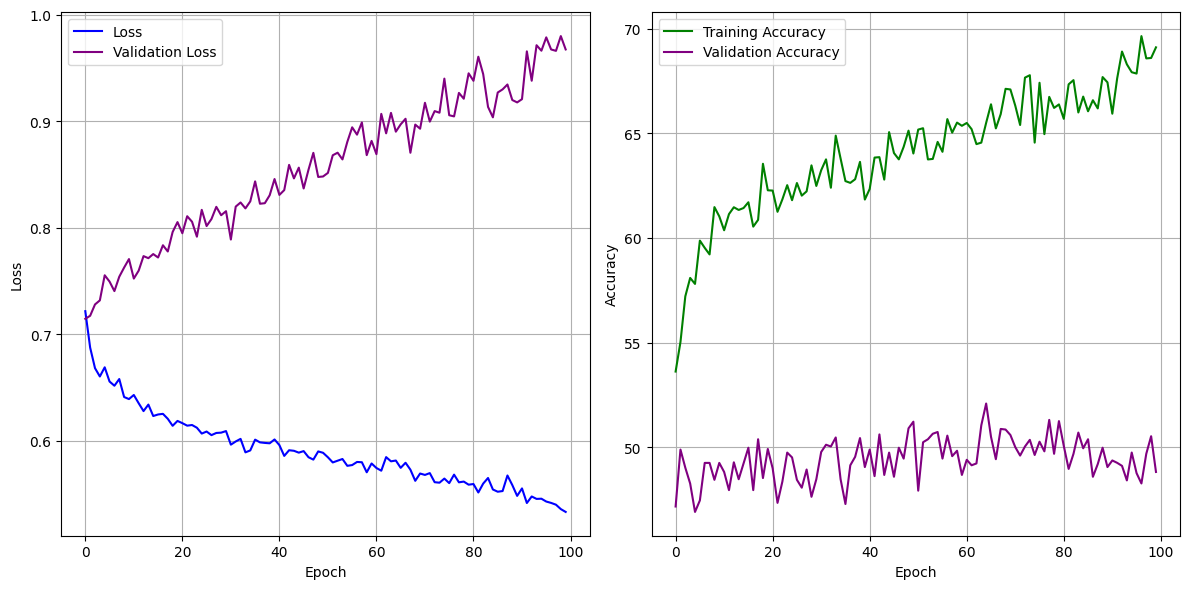

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()